# Predicting Breast Cancer Diagnosis Using RandomForest

This dataset is from the UCI Machine Learning Repository, downloaded from Kaggle. Link [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Ten real-valued features are computed for each cell nucleus:

a) **radius** (mean of distances from center to points on the perimeter)<br>
b) **texture** (standard deviation of gray-scale values)<br>
c) **perimeter**<br>
d) **area**<br>
e) **smoothness** (local variation in radius lengths)<br>
f) **compactness** (perimeter^2 / area - 1.0)<br>
g) **concavity** (severity of concave portions of the contour)<br>
h) **concave points** (number of concave portions of the contour)<br>
i) **symmetry**<br>
j) **fractal dimension** ("coastline approximation" - 1)<br>

The columns names ending with "se" or "worst" refer to the standard error or the maximum of that feature observed, respectively.

The target column is the binary "diagnosis" column.

# Summary

#### RandomForest after 10-fold cross-validation
    * Unscaled
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395
    * Scaled
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395
    * Unscaled after dropping low-importance columns:
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395
    * Scaled after dropping low_importance columns:
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer, precision_recall_curve, average_precision_score

In [2]:
cancer = pd.read_csv('breast_cancer.csv')

cancer = cancer.drop(['Unnamed: 32', 'id'], axis = 1)

In [3]:
diag_map = {'B':0, 'M': 1}

cancer['diagnosis'] = cancer['diagnosis'].map(diag_map)

In [4]:
X = cancer.drop('diagnosis', 1)
y = cancer['diagnosis']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Unscaled

In [7]:
rfc_grid = {
    'n_estimators': [5, 10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 20, 30]
}

model_rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid.fit(X_train, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    9.7s finished


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}


In [8]:
#The best_params_ from the gridsearch lead to overfitting, so I used different hyperparams
# I specify a random state to keep the numbers consistent.

%time
model_rfc = RandomForestClassifier(criterion = 'entropy', 
                                   max_depth = 20, 
                                   n_estimators = 50, 
                                   min_samples_leaf = 5, 
                                   random_state = 20)
model_rfc.fit(X_train, y_train)

y_pred_rfc = model_rfc.predict(X_test)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc.score(X_train, y_train)))
print('Test Score: {}'.format(model_rfc.score(X_test, y_test)))
print(classification_report(y_test, y_pred_rfc))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9868131868131869
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [9]:
cv_scores = cross_val_score(model_rfc, X_test, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc, X_test, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_rfc)))

Mean cross val accuracy: 0.9295454545454545
Mean cross val recall: 0.875
Area under precision-recall curve:0.9395581978201317


In [10]:
importances = model_rfc_grid.best_estimator_.feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
22,perimeter_worst,0.178327
20,radius_worst,0.135823
23,area_worst,0.117635
7,concave points_mean,0.086438
27,concave points_worst,0.080983
0,radius_mean,0.070700
2,perimeter_mean,0.049578
26,concavity_worst,0.045295
6,concavity_mean,0.041842
10,radius_se,0.024816


# Scaled

In [11]:
model_rfc_grid_s = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid_s.fit(X_train_scaled, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.7s


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.1s finished


In [12]:
%time
model_rfc_scale = RandomForestClassifier(criterion = 'entropy',
                                         max_depth = 20, 
                                         n_estimators = 50, 
                                         min_samples_leaf = 5,
                                        random_state = 20)
model_rfc_scale.fit(X_train_scaled, y_train)

y_pred_rfc_s = model_rfc_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_rfc_scale.score(X_test_scaled, y_test)))
print(classification_report(y_test, y_pred_rfc_s))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9868131868131869
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [13]:
cv_scores = cross_val_score(model_rfc_scale, X_test_scaled, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc_scale, X_test_scaled, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_rfc_s)))

Mean cross val accuracy: 0.9295454545454545
Mean cross val recall: 0.875
Area under precision-recall curve:0.9395581978201317


In [14]:
importances = model_rfc_grid_s.best_estimator_.feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
22,perimeter_worst,0.156671
27,concave points_worst,0.136908
6,concavity_mean,0.113489
20,radius_worst,0.107498
7,concave points_mean,0.081505
3,area_mean,0.055833
23,area_worst,0.049220
0,radius_mean,0.047562
13,area_se,0.047530
2,perimeter_mean,0.044116


# Dropping low-importance columns

Using a threshold of 0.1, I drop columns with low importance and test the accuracy of the new model.

## Unscaled

In [15]:
cancer_dropped_u = cancer.drop(columns=['concave points_se'
               ,'symmetry_se'
               ,'compactness_se'
               ,'smoothness_se'
               ,'fractal_dimension_mean'
               ,'concavity_se'
               ,'texture_se'
               ,'fractal_dimension_se'
               ,'fractal_dimension_worst'
               ,'symmetry_mean', 
                'smoothness_worst',
                'compactness_mean', 
                'radius_se', 
                'smoothness_mean',
                'perimeter_se'
                ])

X = cancer_dropped_u.drop(columns = 'diagnosis')

y = cancer_dropped_u['diagnosis']

X_train_op, X_test_op, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [16]:
rfc_grid = {
    'n_estimators': [5, 10, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [5, 20, 30]
}

model_rfc_grid = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid.fit(X_train_op, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.1s finished


In [17]:
%time
model_rfc_op = RandomForestClassifier(criterion = 'entropy',
                                      max_depth = 10, 
                                      n_estimators = 50, 
                                      min_samples_leaf = 5,
                                     random_state = 20)
model_rfc_op.fit(X_train_op, y_train)

y_pred_rfc_op = model_rfc_op.predict(X_test_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc_op),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc_op.score(X_train_op, y_train)))
print('Test Score: {}'.format(model_rfc_op.score(X_test_op, y_test)))
print(classification_report(y_test, y_pred_rfc_op))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9846153846153847
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [18]:
cv_scores = cross_val_score(model_rfc_op, X_test_op, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc_op, X_test_op, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_rfc_op)))

Mean cross val accuracy: 0.9386363636363637
Mean cross val recall: 0.9
Area under precision-recall curve:0.9395581978201317


## Scaled

In [19]:
cancer_dropped_s = cancer.drop(columns=['concave points_se'
                                        ,'fractal_dimension_worst'
                                        ,'smoothness_mean'
                                        ,'texture_se'
                                        ,'fractal_dimension_se'
                                        ,'symmetry_se'
                                        ,'compactness_se'
                                        ,'symmetry_mean'
                                        ,'fractal_dimension_mean'
                                        ,'smoothness_se'
                                        ,'concavity_se'
                                        ,'symmetry_worst'])

X = cancer_dropped_s.drop(columns = 'diagnosis')

y = cancer_dropped_s['diagnosis']

X_train_op_s, X_test_op_s, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [21]:
scaler = StandardScaler()
scaler.fit(X_train_op_s)

X_train_scaled_op = scaler.transform(X_train_op_s)
X_test_scaled_op = scaler.transform(X_test_op_s)

In [22]:
model_rfc_grid_s = GridSearchCV(RandomForestClassifier(), param_grid = rfc_grid, verbose = 1, n_jobs = -1)
model_rfc_grid_s.fit(X_train_scaled_op, y_train)

print(model_rfc_grid.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.9s


{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    6.4s finished


In [23]:
%time
model_rfc_scale_op = RandomForestClassifier(criterion = 'entropy', 
                                            max_depth = 20, 
                                            n_estimators = 50,
                                            min_samples_leaf = 5,
                                           random_state = 20)
model_rfc_scale_op.fit(X_train_scaled_op, y_train)

y_pred_rfc_op_s = model_rfc_scale_op.predict(X_test_scaled_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc_op_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc_scale_op.score(X_train_scaled_op, y_train)))
print('Test Score: {}'.format(model_rfc_scale_op.score(X_test_scaled_op, y_test)))
print(classification_report(y_test, y_pred_rfc_op_s))
print(confusion_df)

Wall time: 0 ns
Training Score: 0.9868131868131869
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41


In [24]:
cv_scores = cross_val_score(model_rfc_scale_op, X_test_scaled_op, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc_scale_op, X_test_scaled_op, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_rfc_op_s)))

Mean cross val accuracy: 0.9287878787878787
Mean cross val recall: 0.875
Area under precision-recall curve:0.9395581978201317


# Visualizations

## Unscaled

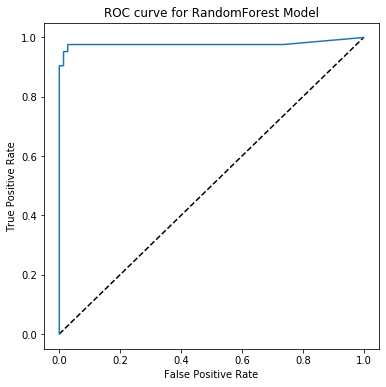

In [25]:
probs = model_rfc.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

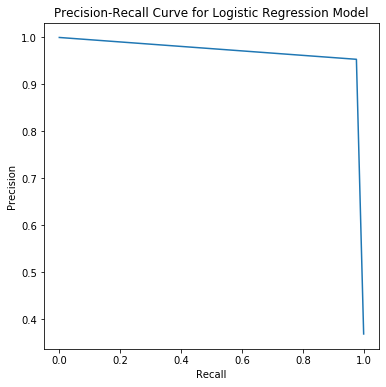

In [26]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rfc)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

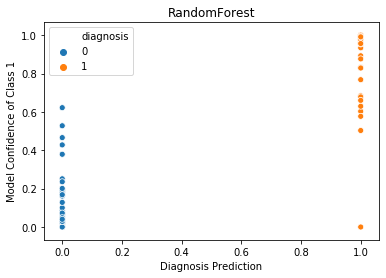

In [27]:
confidence = model_rfc.predict_proba(X_test)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()

## Scaled

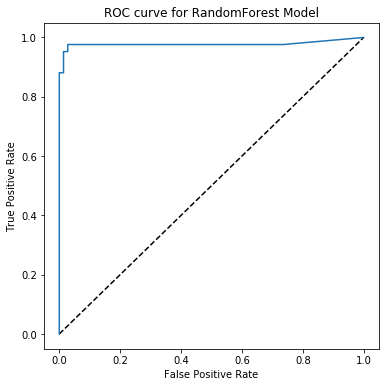

In [28]:
probs = model_rfc_scale.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

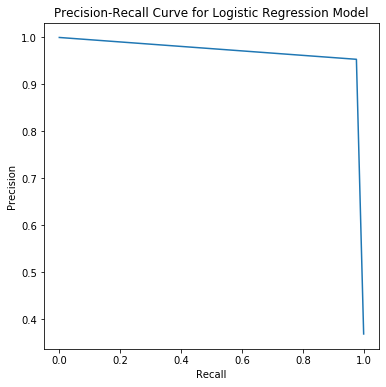

In [29]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rfc_s)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

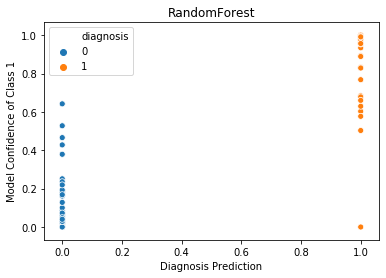

In [30]:
confidence = model_rfc_scale.predict_proba(X_test_scaled)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()

## Unscaled optimized

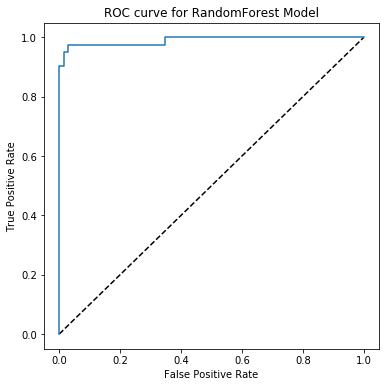

In [31]:
probs = model_rfc_op.predict_proba(X_test_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

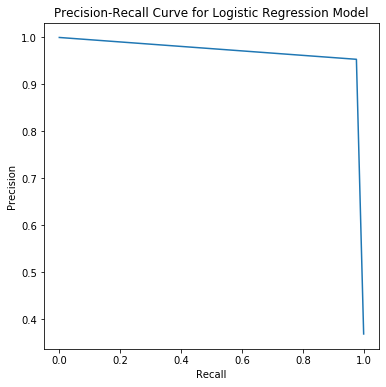

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rfc_op)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

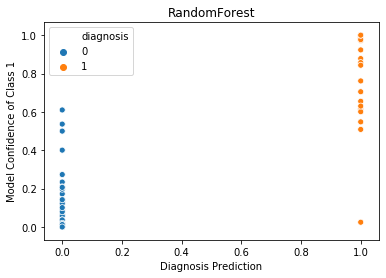

In [33]:
confidence = model_rfc_op.predict_proba(X_test_op)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()

## Scaled optimized

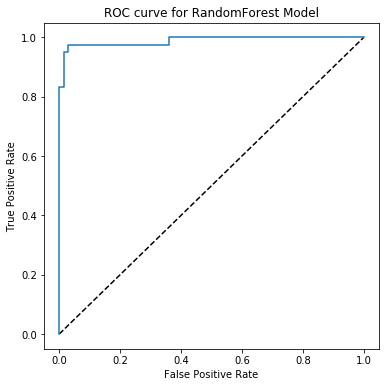

In [34]:
probs = model_rfc_scale_op.predict_proba(X_test_scaled_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for RandomForest Model')
plt.show()

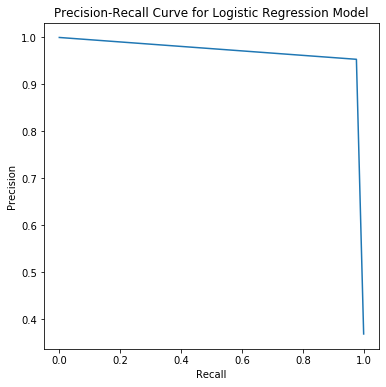

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rfc_op_s)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

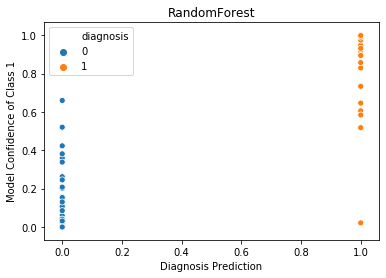

In [36]:
confidence = model_rfc_scale_op.predict_proba(X_test_scaled_op)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('RandomForest')
plt.show()